# Helmholtz setup sanity checks (500×500 grid)

This notebook tests:
- grid resolution (501×501)
- points-per-wavelength
- RHS construction
- solution & residual structure
- basic performance

Goal: numerical confidence before algorithmic experiments.


## Setup run for ω = 4

Goal:
1) choose grid using PPW target (with min 501×501)
2) solve the Helmholtz system once
3) visualize solution and residual (field + spectrum)
4) save outputs for inspection


In [10]:
from pathlib import Path
import numpy as np

from core.config import HelmholtzConfig, PMLConfig
from core.cases import make_default_cases
from core.medium import build_medium
from core.rhs import assemble_rhs
from core.resolution import grid_from_ppw, achieved_ppw

from operators.assemble import assemble_helmholtz_matrix
from operators.solve import solve_linear_system, compute_residual

from diagnostics import plot_field, plot_spectrum, save_npz

print("Imports OK")


Imports OK


In [11]:
# --- user parameters ---
omega = 4.0
ppw_target = 10.0

lx = 1.0
ly = 1.0

# Minimum grid size you requested
n_min = 501

# Constant-medium baseline: c(x,y) = c0 = 1
c_min = 1.0

# PML: keep it defined even if your current assembly doesn't use it yet
pml = PMLConfig(thickness=20, strength=50.0, power=2.0)

outdir = Path("outputs") / "setup" / f"omega_{omega:.0f}"
(outdir / "figs").mkdir(parents=True, exist_ok=True)
(outdir / "fields").mkdir(parents=True, exist_ok=True)

wavelength = 2*np.pi*c_min/omega
print(f"omega = {omega}")
print(f"wavelength ≈ {wavelength:.4f}")


omega = 4.0
wavelength ≈ 1.5708


In [12]:
grid = grid_from_ppw(
    omega=omega,
    ppw=ppw_target,
    lx=lx,
    ly=ly,
    c_min=c_min,
    n_min=n_min,
    make_odd=True,
)

ppw_ach = achieved_ppw(grid, omega, c_min=c_min)

print("grid:", (grid.nx, grid.ny))
print("hx, hy:", (grid.hx, grid.hy))
print("achieved PPW (based on c_min):", ppw_ach)


grid: (501, 501)
hx, hy: (0.002, 0.002)
achieved PPW (based on c_min): 785.3981633974482


In [13]:
cfg = HelmholtzConfig(
    omega=omega,
    grid=grid,
    pml=pml,
    ppw_target=ppw_target,
)

cases = make_default_cases()

# Choose a simple baseline case; adjust key if your cases dict differs.
# Common key names: "const", "default", etc.
case = cases.get("const", next(iter(cases.values())))

print("case:", getattr(case, "name", "unknown"))


case: const


In [14]:
X, Y = cfg.grid.mesh()

c = build_medium(cfg, case, X, Y)
f = assemble_rhs(cfg, case, X, Y)

print("c stats:", float(np.min(c)), float(np.max(c)))
print("f norm:", float(np.linalg.norm(f)))


c stats: 1.0 1.0
f norm: 1.0


In [17]:
A = assemble_helmholtz_matrix(cfg, c)

u = solve_linear_system(A, f)
r = compute_residual(A, u, f)

rel_res = float(np.linalg.norm(r) / (np.linalg.norm(f) + 1e-30))
print("relative residual:", rel_res)


relative residual: 1.72170693214606e-13


saved figures to: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\experiments\outputs\setup\omega_4\figs


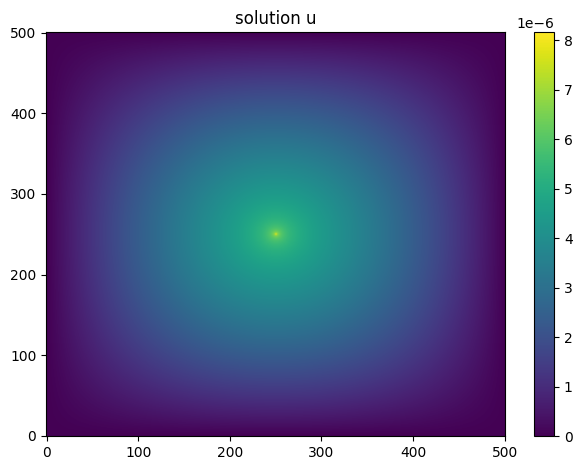

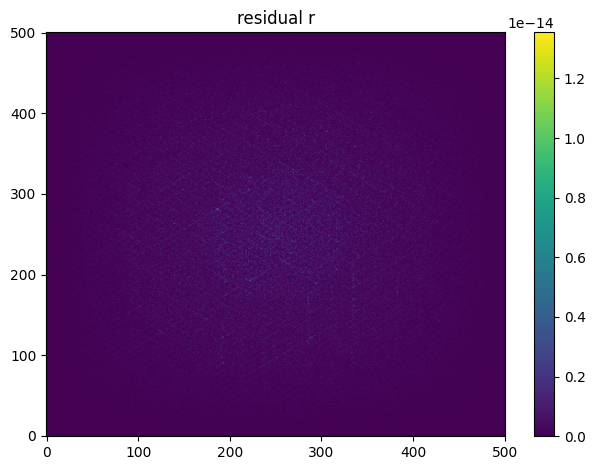

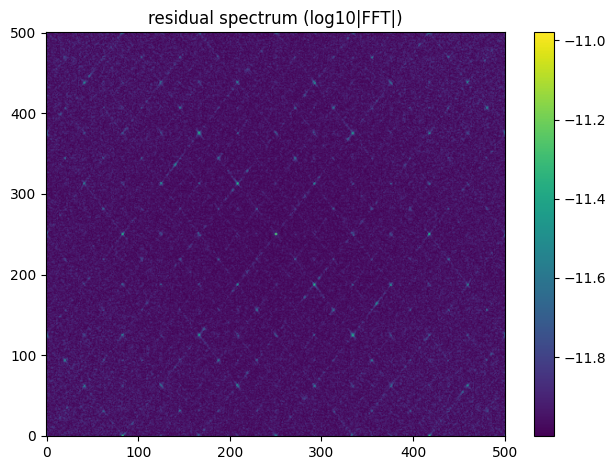

In [18]:
plot_field(grid.nx, grid.ny, u, "solution u", outdir / "figs" / "u.png")
plot_field(grid.nx, grid.ny, r, "residual r", outdir / "figs" / "residual.png")
plot_spectrum(grid.nx, grid.ny, r, "residual spectrum", outdir / "figs" / "residual_spectrum.png")

print("saved figures to:", (outdir / "figs").resolve())


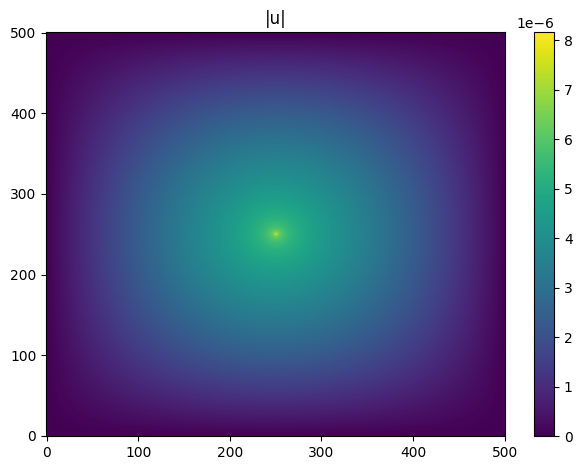

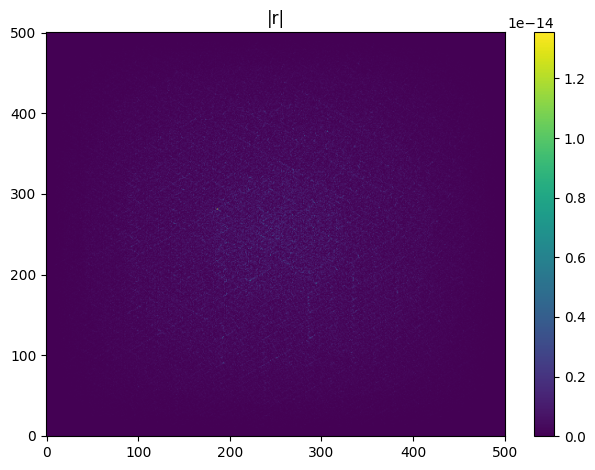

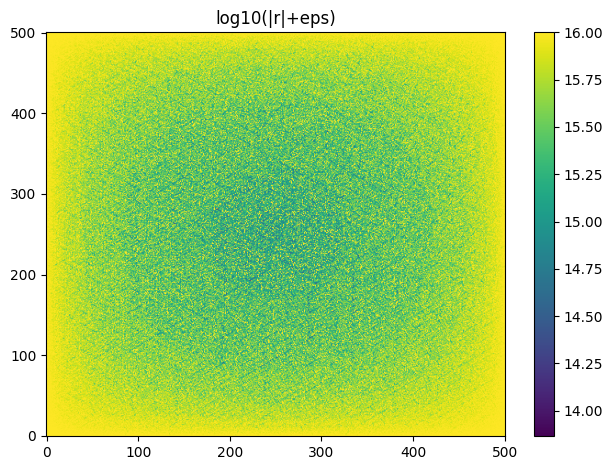

In [20]:
U = u.reshape(grid.nx, grid.ny)
R = r.reshape(grid.nx, grid.ny)

u_abs = np.abs(U)
r_abs = np.abs(R)

plot_field(grid.nx, grid.ny, u_abs.reshape(-1), "|u|", outdir / "figs" / "u_abs.png")
plot_field(grid.nx, grid.ny, r_abs.reshape(-1), "|r|", outdir / "figs" / "r_abs.png")

eps = 1e-16
r_log = np.log10(r_abs + eps)
plot_field(grid.nx, grid.ny, r_log.reshape(-1), "log10(|r|+eps)", outdir / "figs" / "r_log.png")


In [19]:
save_npz(
    outdir / "fields" / "setup_fields.npz",
    u=u, r=r, f=f, c=c,
    omega=np.array(cfg.omega),
    nx=np.array(grid.nx),
    ny=np.array(grid.ny),
    lx=np.array(grid.lx),
    ly=np.array(grid.ly),
    ppw_target=np.array(ppw_target),
)

print("saved fields to:", (outdir / "fields").resolve())


saved fields to: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\experiments\outputs\setup\omega_4\fields
